In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../')

from adasubtraction.waveeqmod import Acoustic2DDevito

plt.style.use('default')

In [3]:
nx, nz = 201, 201
dx, dz = 10, 10
dt = 1

origin = (0, 0)
shape = (nx, nz)
spacing = (dx, dz)

In [4]:
v = np.empty(shape, dtype=np.float32)  
v[:, : 51] = 2000
v[:, 51: 81] = 3800
v[:, 81:] = 5000

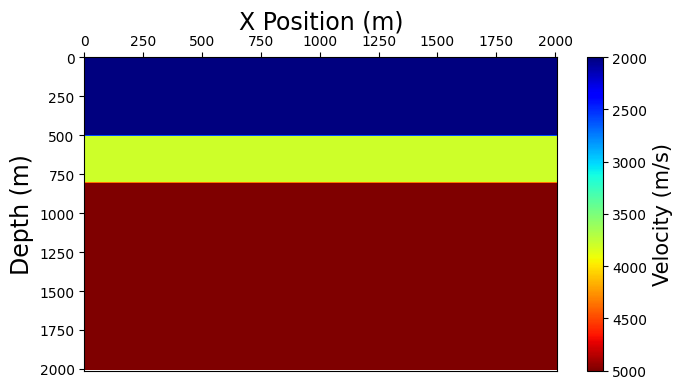

In [5]:
fig, axs = plt.subplots(1, 1, figsize=(7, 4))  
im = axs.imshow(v.T, extent=[0, nx*dx, nz*dz, 0],cmap='jet') 
axs.axis('tight')  
axs.set_ylabel('Depth (m)', fontsize=17)
axs.set_xlabel('X Position (m)', fontsize=17)

cbar = fig.colorbar(im, ax=axs)
cbar.ax.invert_yaxis()  # 颠倒colorbar
cbar.set_label('Velocity (m/s)', fontsize=15)
# 设置X轴坐标和刻度位置在上方
axs.xaxis.set_ticks_position('top')
axs.xaxis.set_label_position('top')
plt.tight_layout()
plt.show()

In [6]:
nbl = 200
space_order = 5
t0 = 0
tn = 1500 # ms
f0 = 15 # Hz
fs_free = True # 上表面自由边界
fs_damp = False
nsrc = nx
nrec = nx
depth = 5

In [7]:
awe_free = Acoustic2DDevito()

# 速度模型
awe_free.create_model(
    shape,                 # 模型的形状（水平点数，深度点数）
    origin,                # 模型的原点位置（水平和深度均为0米）
    spacing,               # 网格间距）
    v,                     # 速度模型（需要转置以匹配内部坐标格式）
    space_order,           # 数值差分的空间阶数
    nbl=nbl,               # 模型边界层厚度
    fs=fs_free             # 是否设置自由表面条件（True 表示有自由表面）
)


# 创建几何布置
awe_free.create_geometry(
    src_x=np.arange(0, nsrc) * spacing[0],      # 激发源的水平位置（每隔12米一个源）
    src_z=depth,                                # 激发源的深度位置（固定在5米深度）
    rec_x=np.arange(0, nrec) * spacing[0],      # 接收器的水平位置（每隔12米一个接收器）
    rec_z=depth,                                # 接收器的深度位置（固定在5米深度）
    t0=t0,                                      # 模拟的起始时间（毫秒）
    tn=tn,                                      # 模拟的总时间（毫秒）
    src_type='Ricker',                          # 激发源的类型（Ricker wavelet）
    f0=f0                                       # 激发源的主频率（25 Hz）
)

# 打印时间步长
# geometry.dt 是计算得到的时间步长（由模型参数和 CFL 条件决定）
print(awe_free.geometry.dt)

Operator `initdamp` ran in 0.01 s


1.083


In [8]:
awe_damp = Acoustic2DDevito()

# 速度模型
awe_damp.create_model(
    shape,                 # 模型的形状（水平点数，深度点数）
    origin,                # 模型的原点位置（水平和深度均为0米）
    spacing,               # 网格间距）
    v,                     # 速度模型（需要转置以匹配内部坐标格式）
    space_order,           # 数值差分的空间阶数
    nbl=nbl,               # 模型边界层厚度
    fs=fs_damp             # 是否设置自由表面条件（True 表示有自由表面）
)


# 创建几何布置
awe_damp.create_geometry(
    src_x=np.arange(0, nsrc) * spacing[0],      # 激发源的水平位置（每隔12米一个源）
    src_z=depth,                                # 激发源的深度位置（固定在5米深度）
    rec_x=np.arange(0, nrec) * spacing[0],      # 接收器的水平位置（每隔12米一个接收器）
    rec_z=depth,                                # 接收器的深度位置（固定在5米深度）
    t0=t0,                                      # 模拟的起始时间（毫秒）
    tn=tn,                                      # 模拟的总时间（毫秒）
    src_type='Ricker',                          # 激发源的类型（Ricker wavelet）
    f0=f0                                       # 激发源的主频率（25 Hz）
)

# 打印时间步长
# geometry.dt 是计算得到的时间步长（由模型参数和 CFL 条件决定）
print(awe_damp.geometry.dt)

Operator `initdamp` ran in 0.01 s


1.083


In [9]:
isrc = 101

data_free, _, _ = awe_free.solve_one_shot(isrc, dt=dt)
data_free = data_free.data

data_damp, _, _ = awe_damp.solve_one_shot(isrc, dt=dt)
data_damp = data_damp.data

data_free.shape

Operator `Forward` ran in 0.18 s
Operator `Forward` ran in 0.24 s


(1503, 201)

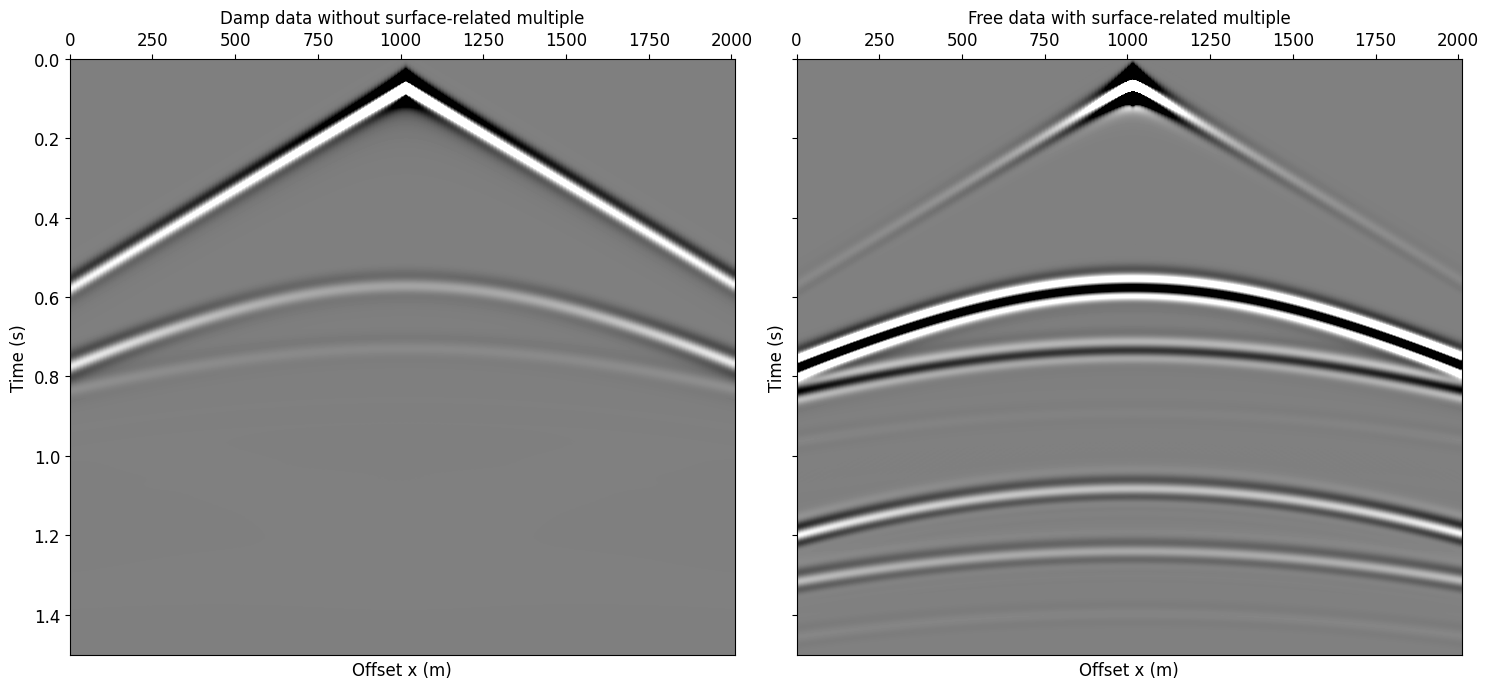

In [13]:
vmax = 1e-1
vmin = -vmax

fig, axs = plt.subplots(1, 2, figsize=(15, 7),sharey=True)

axs[0].imshow(data_damp, aspect='auto', vmin=vmin*30, vmax=vmax*30, extent=[0, nx*dx, data_free.shape[0] * dt * 1e-3, 0], cmap='grey')
axs[0].set_title('Damp data without surface-related multiple',fontsize=12)
axs[0].set_xlabel('Offset x (m)',fontsize=12)
axs[0].set_ylabel('Time (s)',fontsize=12)
axs[0].tick_params(axis='x', labelsize=12)
axs[0].tick_params(axis='y', labelsize=12)

axs[1].imshow(data_free, aspect='auto', vmin=vmin, vmax=vmax, extent=[0, nx*dx, data_free.shape[0] * dt * 1e-3, 0], cmap='grey')
axs[1].set_title('Free data with surface-related multiple',fontsize=12)
axs[1].set_xlabel('Offset x (m)',fontsize=12)
axs[1].set_ylabel('Time (s)',fontsize=12)
axs[1].tick_params(axis='x', labelsize=12)
axs[1].tick_params(axis='y', labelsize=12)

plt.tight_layout()
axs[0].xaxis.set_ticks_position('top')
axs[1].xaxis.set_ticks_position('top')